In [1]:
# Import Neccessary Libraries:

import numpy as np
import pandas as pd
import torch
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.nn.functional as F
from torch import optim
from tqdm import tqdm
import pickle
from torch.optim.lr_scheduler import StepLR
import time
from sklearn.model_selection import train_test_split
from PIL import Image

In [2]:
# To mount drive:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Checking GPU:
print(torch.cuda.get_device_name(0))

Tesla P100-PCIE-16GB


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [5]:
# # To perform Transformations to the Data
# transform = transforms.ToTensor()

In [6]:
!cp "/content/drive/MyDrive/CS5100 Project/resized_images.zip" -r "/content/resized_images.zip"
!unzip /content/resized_images.zip -d /content/resized_images

Streaming output truncated to the last 5000 lines.
  inflating: /content/resized_images/00026538_006.png  
  inflating: /content/resized_images/00026538_007.png  
  inflating: /content/resized_images/00026538_008.png  
  inflating: /content/resized_images/00026538_009.png  
  inflating: /content/resized_images/00026538_010.png  
  inflating: /content/resized_images/00026538_011.png  
  inflating: /content/resized_images/00026538_012.png  
  inflating: /content/resized_images/00026538_013.png  
  inflating: /content/resized_images/00026538_014.png  
  inflating: /content/resized_images/00026538_015.png  
  inflating: /content/resized_images/00026538_016.png  
  inflating: /content/resized_images/00026538_017.png  
  inflating: /content/resized_images/00026538_018.png  
  inflating: /content/resized_images/00026538_019.png  
  inflating: /content/resized_images/00026538_020.png  
  inflating: /content/resized_images/00026538_021.png  
  inflating: /content/resized_images/00026538_022.png

In [7]:
def read_pickle_file(filepath):
  with open(filepath, "rb") as f:
    return pickle.load(f)

In [8]:
# Function to Load Trained Models:

def loadModel(model_name, model):
  state_dict = torch.load("/content/drive/MyDrive/CS5100 Project/Pretrained Models/" + model_name + ".pt")
  model.load_state_dict(state_dict)
  return model

In [9]:
class ChestXRay_ImageDataset(Dataset):

    def __init__(self, metadata, transforms):
        self.metadata = metadata
        self.transforms = transforms

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        image_path = self.metadata["image_path"][index]
        # hurricane_image = io.imread(image_path)
        xray_image = Image.open(image_path).convert("RGB")
        label = self.metadata["Disease_Labels"][index]

        if self.transforms:
            xray_image = self.transforms(xray_image)

        return xray_image, label

In [10]:
def display_sample_images(dataloader, batch_size, sample_size, num_rows, class_dict):
  sample_size = min(sample_size, batch_size)
  images, labels = next(iter(dataloader))
  images = images.numpy()

  fig = plt.figure(figsize = (30, 10))
  for i in np.arange(sample_size):
      ax = fig.add_subplot(num_rows, sample_size/num_rows, i+1, xticks = [], yticks = [])
      ax.imshow(np.squeeze(np.transpose(images[i], (1, 2 ,0))))
      ax.set_title(str(class_dict[labels[i].item()]))
  
  return

In [11]:
# Write and Read Lists:
# Used to Save Train and Test Losses for all Epochs

def write_lists(list_, fname):
  with open("/content/drive/MyDrive/CS5100 Project/Loss Files/" + fname, 'w') as f:
      for s in list_:
          f.write(str(s) + '\n')

def read_lists(fname):
  with open("/content/drive/MyDrive/CS5100 Project/Loss Files/" + fname, 'r') as f:
      list_ = [float(line.rstrip('\n')) for line in f]
  return list_


In [12]:
# Training and Validating Model on Data:

def train(epoch, model, trainloader, validloader, criterion, optimizer, model_name, valid_loss_min = np.Inf):
  # Training the model:
  start = time.time()
  
  train_losses, validation_losses = [], []
  for e in range(epochs):
    model.train()
    train_loss, validation_loss = 0.0, 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()*images.size(0)
    
    # Validate the Model:
    model.eval()
    for images, labels in validloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      validation_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(trainloader.dataset)
    validation_loss = train_loss/len(validloader.dataset)
    train_losses.append(train_loss)
    validation_losses.append(validation_loss)

    print("Epoch: {}/{}, Train Loss: {:.5f}, Validation Loss: {:.5f}".format(e+1, epochs, train_loss, validation_loss))
    
    if validation_loss <= valid_loss_min:
      print("Decrease in Validation Loss: {:.5f} to {:.5f}. Saving Model...".format(valid_loss_min, validation_loss))
      # torch.save(model.state_dict(), "/content/" + model_name + ".pt")
      torch.save(model.state_dict(), "/content/drive/MyDrive/CS5100 Project/Pretrained Models/" + model_name + ".pt")
      valid_loss_min = validation_loss

  write_lists(train_losses, "train_losses_" + model_name)
  write_lists(validation_losses, "validation_losses_" + model_name) 
  end = time.time()
  hours, rem = divmod(end-start, 3600)
  minutes, seconds = divmod(rem, 60)
  print("\nTime Taken for Training: {:0>2}:{:0>2}:{:05.2f}\n".format(int(hours),int(minutes),seconds))
  
  return train_losses, validation_losses


In [13]:
# Testing Model on Data:

def test(model, testloader, criterion, num_classes):

  test_loss, accuracy = 0.0, 0.0
  class_correct = list(0. for i in range(num_classes))
  class_total = list(0. for i in range(num_classes))
  model.eval()

  for images, labels in testloader:
      images, labels = images.to(device), labels.to(device)
      output = model(images)
      loss = criterion(output, labels)
      test_loss += loss.item()*images.size(0)
      _, pred = torch.max(output, 1)
      correct = np.squeeze(pred.eq(labels.data.view_as(pred)))

      for i in range(len(labels)):
          label = labels.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  test_loss = test_loss/len(testloader.sampler)
  print("Test Loss: {}".format(test_loss))

  for i in range(num_classes):
      if class_total[i] > 0:
          print("Test Accuracy of {}: {:.3f}%. Frac: {}/{}".format(str(class_dict[i]), 100*(class_correct[i]/class_total[i]), 
                                                        np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print("Test Accuracy of {}: N/A (no training examples)".format(classes[i]))
  print("\n Test Accuracy (Overall): {:.3f}. Frac {}/{}".format((100 * np.sum(class_correct)/np.sum(class_total)), 
                                                            np.sum(class_correct), np.sum(class_total)))
  
  return
  

In [14]:
filepath = "/content/class_labels_dict.pkl"
class_dict = read_pickle_file(filepath)

In [ ]:
print(class_dict)

{0: 'Atelectasis', 1: 'Cardiomegaly', 2: 'Consolidation', 3: 'Edema', 4: 'Effusion', 5: 'Emphysema', 6: 'Fibrosis', 7: 'Infiltration', 8: 'Mass', 9: 'No Finding', 10: 'Nodule', 11: 'Pleural_Thickening', 12: 'Pneumonia', 13: 'Pneumothorax'}


In [15]:
df = pd.read_csv("/content/df_labels_le.csv")

In [16]:
df.head()

,Image Index,value,Disease_Labels
0,00000001_000.png,Cardiomegaly,1
1,00000001_002.png,Cardiomegaly,1
2,00000004_000.png,Mass,8
3,00000005_007.png,Effusion,4
4,00000008_000.png,Cardiomegaly,1


In [17]:
df["image_path"] = "/content/resized_images/" + df["Image Index"]

In [18]:
df.head()

,Image Index,value,Disease_Labels,image_path
0,00000001_000.png,Cardiomegaly,1,/content/resized_images/00000001_000.png
1,00000001_002.png,Cardiomegaly,1,/content/resized_images/00000001_002.png
2,00000004_000.png,Mass,8,/content/resized_images/00000004_000.png
3,00000005_007.png,Effusion,4,/content/resized_images/00000005_007.png
4,00000008_000.png,Cardiomegaly,1,/content/resized_images/00000008_000.png


In [19]:
X, y = df["image_path"], df["Disease_Labels"]

In [20]:
print(X.shape, y.shape)

(77637,) (77637,)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y, shuffle=True)
X_train, X_test = pd.DataFrame(X_train), pd.DataFrame(X_test)

In [22]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(62109, 1) (62109,)
(15528, 1) (15528,)


In [23]:
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1).reset_index().drop("index", axis=1)

rs = np.random.RandomState(101)
msk = rs.rand(len(train_df)) < 0.85
valid_df = train_df[~msk].reset_index().drop("index", axis=1)
train_df = train_df[msk].reset_index().drop("index", axis=1)


In [24]:
print(train_df.shape, valid_df.shape, test_df.shape)

(52696, 2) (9413, 2) (15528, 2)


In [25]:
train_df["Disease_Labels"].value_counts()

7     10632
4      9410
0      6352
13     4179
9      4115
8      3942
10     3692
2      3296
1      1729
11     1694
5      1292
3      1227
12      639
6       497
Name: Disease_Labels, dtype: int64

In [26]:
test_df["Disease_Labels"].value_counts()

7     3134
4     2768
0     1876
13    1234
9     1207
8     1157
10    1093
2      968
1      509
11     502
5      381
3      361
12     193
6      145
Name: Disease_Labels, dtype: int64

In [27]:
valid_df["Disease_Labels"].value_counts()

7     1905
4     1660
0     1153
13     756
9      714
8      688
10     678
2      574
11     313
1      307
5      230
3      216
12     134
6       85
Name: Disease_Labels, dtype: int64

In [28]:
transform = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        transforms.Resize((224, 224)),
        # transforms.Grayscale(num_output_channels=1),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        # transforms.Normalize([0.5], [0.5])
])

In [29]:
trainset = ChestXRay_ImageDataset(train_df, transform)
testset = ChestXRay_ImageDataset(test_df, transform)
validset = ChestXRay_ImageDataset(valid_df, transform)

trainloader = DataLoader(trainset, batch_size=128, shuffle=True)
testloader = DataLoader(testset, batch_size=128, shuffle=True)
validloader = DataLoader(validset, batch_size=128, shuffle=True)

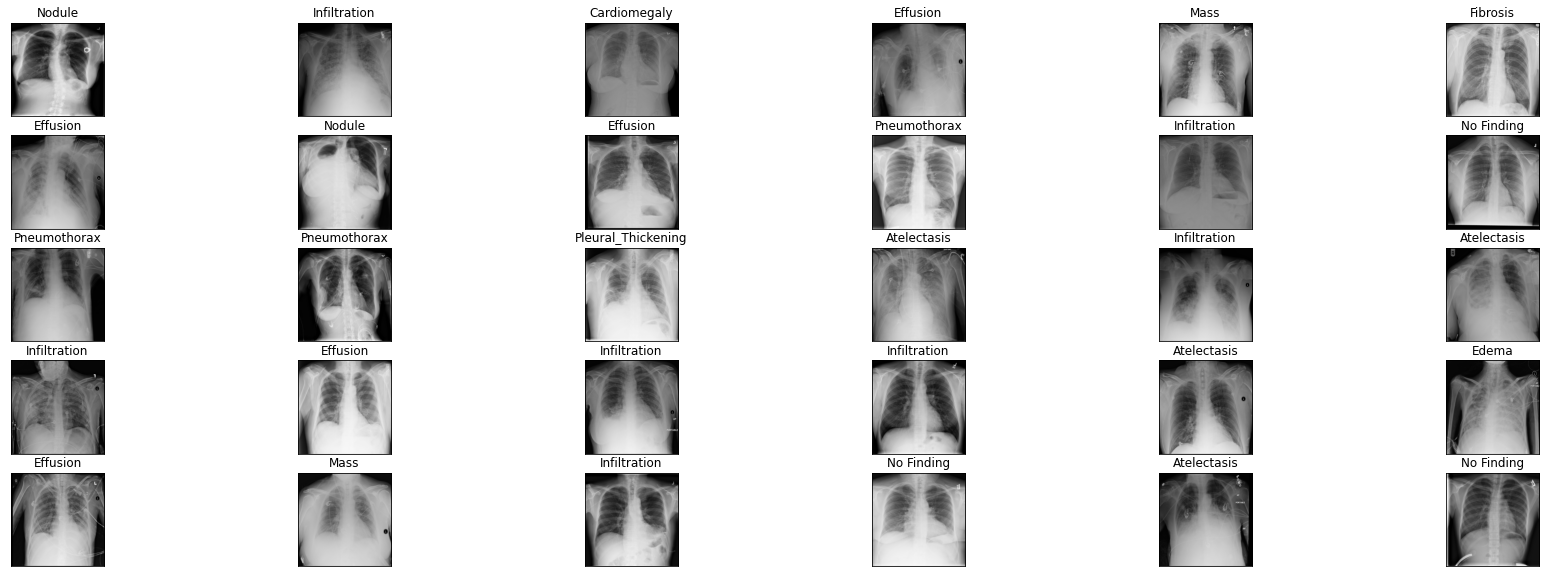

In [30]:
batch_size = 64
sample_size = 30
num_rows = 5
display_sample_images(testloader, batch_size, sample_size, num_rows, class_dict)

In [ ]:
# VGG16 Classifier:

vgg16 = models.vgg16(pretrained = True)
# vgg16

# Freeze Parameters so we dont backprop through them:
for param in vgg16.parameters():
    param.requires_grad = False

"""
classifier = nn.Sequential(nn.Linear(25088, 4096, bias = True),
                           nn.ReLU(inplace = True),
                           nn.Dropout(0.2),
                           nn.Linear(4096, 4096, bias = True),
                           nn.ReLU(inplace = True),
                           nn.Dropout(0.2),
                           nn.Linear(4096, 225, bias = True),
                           nn.LogSoftmax(dim = 1))

vgg16.classifier = classifier
vgg16.classifier

"""

vgg16.classifier[6] = nn.Linear(4096, len(class_dict), bias = True)
# vgg16.classifier
vgg16.to(device)

# vgg16.avgpool = nn.AdaptiveAvgPool2d(output_size = (2, 2))
# vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.classifier.parameters(), lr = 0.0001)


In [ ]:
epochs = 50
model_name = "vgg16_adam_e50_bs128_lr00001"
train_losses, validation_losses = train(epochs, vgg16, trainloader, validloader, criterion, optimizer, model_name, valid_loss_min = np.Inf)

Epoch: 1/50, Train Loss: 2.31776, Validation Loss: 0.00025
Decrease in Validation Loss: inf to 0.00025. Saving Model...
Epoch: 2/50, Train Loss: 2.26063, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00025 to 0.00024. Saving Model...
Epoch: 3/50, Train Loss: 2.24028, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 4/50, Train Loss: 2.22810, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 5/50, Train Loss: 2.21873, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 6/50, Train Loss: 2.21200, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00024 to 0.00023. Saving Model...
Epoch: 7/50, Train Loss: 2.20643, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 8/50, Train Loss: 2.20332, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 9/50,

For VGG16 epochs: 50, bs: 64, lr:0.0003, Adam, CEL ==>

Epoch: 1/50, Train Loss: 2.28554, Validation Loss: 0.00024
Decrease in Validation Loss: inf to 0.00024. Saving Model...
Epoch: 2/50, Train Loss: 2.24239, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 3/50, Train Loss: 2.22811, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 4/50, Train Loss: 2.22237, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 5/50, Train Loss: 2.21775, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 6/50, Train Loss: 2.21646, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 7/50, Train Loss: 2.21535, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 8/50, Train Loss: 2.21356, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 9/50, Train Loss: 2.20949, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00024 to 0.00023. Saving Model...
Epoch: 10/50, Train Loss: 2.20985, Validation Loss: 0.00023
Epoch: 11/50, Train Loss: 2.20690, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 12/50, Train Loss: 2.20458, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 13/50, Train Loss: 2.20518, Validation Loss: 0.00023
Epoch: 14/50, Train Loss: 2.20700, Validation Loss: 0.00023
Epoch: 15/50, Train Loss: 2.20448, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 16/50, Train Loss: 2.20534, Validation Loss: 0.00023
Epoch: 17/50, Train Loss: 2.20095, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 18/50, Train Loss: 2.20319, Validation Loss: 0.00023
Epoch: 19/50, Train Loss: 2.20380, Validation Loss: 0.00023
Epoch: 20/50, Train Loss: 2.20010, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 21/50, Train Loss: 2.20219, Validation Loss: 0.00023
Epoch: 22/50, Train Loss: 2.20274, Validation Loss: 0.00023
Epoch: 23/50, Train Loss: 2.20128, Validation Loss: 0.00023
Epoch: 24/50, Train Loss: 2.20163, Validation Loss: 0.00023
Epoch: 25/50, Train Loss: 2.19891, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 26/50, Train Loss: 2.19744, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 27/50, Train Loss: 2.20165, Validation Loss: 0.00023
Epoch: 28/50, Train Loss: 2.19838, Validation Loss: 0.00023
Epoch: 29/50, Train Loss: 2.19874, Validation Loss: 0.00023
Epoch: 30/50, Train Loss: 2.20038, Validation Loss: 0.00023
Epoch: 31/50, Train Loss: 2.19978, Validation Loss: 0.00023
Epoch: 32/50, Train Loss: 2.19975, Validation Loss: 0.00023
Epoch: 33/50, Train Loss: 2.19574, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 34/50, Train Loss: 2.19687, Validation Loss: 0.00023
Epoch: 35/50, Train Loss: 2.19827, Validation Loss: 0.00023
Epoch: 36/50, Train Loss: 2.19958, Validation Loss: 0.00023
Epoch: 37/50, Train Loss: 2.19816, Validation Loss: 0.00023
Epoch: 38/50, Train Loss: 2.19544, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 39/50, Train Loss: 2.19912, Validation Loss: 0.00023
Epoch: 40/50, Train Loss: 2.19746, Validation Loss: 0.00023
Epoch: 41/50, Train Loss: 2.19474, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 42/50, Train Loss: 2.19657, Validation Loss: 0.00023
Epoch: 43/50, Train Loss: 2.19800, Validation Loss: 0.00023
Epoch: 44/50, Train Loss: 2.19834, Validation Loss: 0.00023
Epoch: 45/50, Train Loss: 2.19350, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 46/50, Train Loss: 2.19782, Validation Loss: 0.00023
Epoch: 47/50, Train Loss: 2.19661, Validation Loss: 0.00023
Epoch: 48/50, Train Loss: 2.19700, Validation Loss: 0.00023
Epoch: 49/50, Train Loss: 2.19594, Validation Loss: 0.00023
Epoch: 50/50, Train Loss: 2.19601, Validation Loss: 0.00023

Time Taken for Training: 03:43:49.93

For VGG16 epochs: 50, bs: 128, lr:0.0001, Adam, CEL ==>

Epoch: 1/50, Train Loss: 2.31776, Validation Loss: 0.00025
Decrease in Validation Loss: inf to 0.00025. Saving Model...
Epoch: 2/50, Train Loss: 2.26063, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00025 to 0.00024. Saving Model...
Epoch: 3/50, Train Loss: 2.24028, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 4/50, Train Loss: 2.22810, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 5/50, Train Loss: 2.21873, Validation Loss: 0.00024
Decrease in Validation Loss: 0.00024 to 0.00024. Saving Model...
Epoch: 6/50, Train Loss: 2.21200, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00024 to 0.00023. Saving Model...
Epoch: 7/50, Train Loss: 2.20643, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 8/50, Train Loss: 2.20332, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 9/50, Train Loss: 2.19777, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 10/50, Train Loss: 2.19632, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 11/50, Train Loss: 2.19417, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 12/50, Train Loss: 2.19199, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 13/50, Train Loss: 2.18784, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 14/50, Train Loss: 2.18813, Validation Loss: 0.00023
Epoch: 15/50, Train Loss: 2.18770, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 16/50, Train Loss: 2.18575, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 17/50, Train Loss: 2.18166, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 18/50, Train Loss: 2.17963, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 19/50, Train Loss: 2.17880, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 20/50, Train Loss: 2.17804, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 21/50, Train Loss: 2.17797, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 22/50, Train Loss: 2.17536, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 23/50, Train Loss: 2.17855, Validation Loss: 0.00023
Epoch: 24/50, Train Loss: 2.17196, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 25/50, Train Loss: 2.17515, Validation Loss: 0.00023
Epoch: 26/50, Train Loss: 2.17315, Validation Loss: 0.00023
Epoch: 27/50, Train Loss: 2.17335, Validation Loss: 0.00023
Epoch: 28/50, Train Loss: 2.17104, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 29/50, Train Loss: 2.17430, Validation Loss: 0.00023
Epoch: 30/50, Train Loss: 2.17071, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 31/50, Train Loss: 2.17265, Validation Loss: 0.00023
Epoch: 32/50, Train Loss: 2.16748, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 33/50, Train Loss: 2.16996, Validation Loss: 0.00023
Epoch: 34/50, Train Loss: 2.17044, Validation Loss: 0.00023
Epoch: 35/50, Train Loss: 2.16834, Validation Loss: 0.00023
Epoch: 36/50, Train Loss: 2.16944, Validation Loss: 0.00023
Epoch: 37/50, Train Loss: 2.16621, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 38/50, Train Loss: 2.16651, Validation Loss: 0.00023
Epoch: 39/50, Train Loss: 2.16858, Validation Loss: 0.00023
Epoch: 40/50, Train Loss: 2.16827, Validation Loss: 0.00023
Epoch: 41/50, Train Loss: 2.16563, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 42/50, Train Loss: 2.16488, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 43/50, Train Loss: 2.16827, Validation Loss: 0.00023
Epoch: 44/50, Train Loss: 2.16521, Validation Loss: 0.00023
Epoch: 45/50, Train Loss: 2.16334, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 46/50, Train Loss: 2.16426, Validation Loss: 0.00023
Epoch: 47/50, Train Loss: 2.16048, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00023 to 0.00023. Saving Model...
Epoch: 48/50, Train Loss: 2.16431, Validation Loss: 0.00023
Epoch: 49/50, Train Loss: 2.16409, Validation Loss: 0.00023
Epoch: 50/50, Train Loss: 2.16320, Validation Loss: 0.00023

Time Taken for Training: 03:40:44.61

For VGG16 epochs: 50, bs: 64, lr:0.003, Adam, CEL ==>


Epoch: 1/50, Train Loss: 2.67199, Validation Loss: 0.00028
Decrease in Validation Loss: inf to 0.00028. Saving Model...
Epoch: 2/50, Train Loss: 2.72251, Validation Loss: 0.00029
Epoch: 3/50, Train Loss: 2.73586, Validation Loss: 0.00029
Epoch: 4/50, Train Loss: 2.74349, Validation Loss: 0.00029
Epoch: 5/50, Train Loss: 2.74190, Validation Loss: 0.00029
Epoch: 6/50, Train Loss: 2.73055, Validation Loss: 0.00029
Epoch: 7/50, Train Loss: 2.74791, Validation Loss: 0.00029
Epoch: 8/50, Train Loss: 2.75149, Validation Loss: 0.00029
Epoch: 9/50, Train Loss: 2.74317, Validation Loss: 0.00029
Epoch: 10/50, Train Loss: 2.74896, Validation Loss: 0.00029
Epoch: 11/50, Train Loss: 2.72996, Validation Loss: 0.00029
Epoch: 12/50, Train Loss: 2.75307, Validation Loss: 0.00029
Epoch: 13/50, Train Loss: 2.73515, Validation Loss: 0.00029
Epoch: 14/50, Train Loss: 2.74478, Validation Loss: 0.00029
Epoch: 15/50, Train Loss: 2.75202, Validation Loss: 0.00029
Epoch: 16/50, Train Loss: 2.73667, Validation Loss: 0.00029
Epoch: 17/50, Train Loss: 2.74505, Validation Loss: 0.00029
Epoch: 18/50, Train Loss: 2.73358, Validation Loss: 0.00029
Epoch: 19/50, Train Loss: 2.74158, Validation Loss: 0.00029
Epoch: 20/50, Train Loss: 2.75046, Validation Loss: 0.00029
Epoch: 21/50, Train Loss: 2.72986, Validation Loss: 0.00029
Epoch: 22/50, Train Loss: 2.74996, Validation Loss: 0.00029
Epoch: 23/50, Train Loss: 2.73268, Validation Loss: 0.00029
Epoch: 24/50, Train Loss: 2.73653, Validation Loss: 0.00029
Epoch: 25/50, Train Loss: 2.74742, Validation Loss: 0.00029
Epoch: 26/50, Train Loss: 2.73605, Validation Loss: 0.00029
Epoch: 27/50, Train Loss: 2.73706, Validation Loss: 0.00029
Epoch: 28/50, Train Loss: 2.74785, Validation Loss: 0.00029
Epoch: 29/50, Train Loss: 2.74744, Validation Loss: 0.00029
Epoch: 30/50, Train Loss: 2.75083, Validation Loss: 0.00029
Epoch: 31/50, Train Loss: 2.74357, Validation Loss: 0.00029
Epoch: 32/50, Train Loss: 2.73047, Validation Loss: 0.00029
Epoch: 33/50, Train Loss: 2.75133, Validation Loss: 0.00029
Epoch: 34/50, Train Loss: 2.74364, Validation Loss: 0.00029
Epoch: 35/50, Train Loss: 2.75224, Validation Loss: 0.00029
Epoch: 36/50, Train Loss: 2.74243, Validation Loss: 0.00029
Epoch: 37/50, Train Loss: 2.73548, Validation Loss: 0.00029
Epoch: 38/50, Train Loss: 2.75010, Validation Loss: 0.00029
Epoch: 39/50, Train Loss: 2.73646, Validation Loss: 0.00029
Epoch: 40/50, Train Loss: 2.74458, Validation Loss: 0.00029
Epoch: 41/50, Train Loss: 2.74269, Validation Loss: 0.00029
Epoch: 42/50, Train Loss: 2.75820, Validation Loss: 0.00029
Epoch: 43/50, Train Loss: 2.73327, Validation Loss: 0.00029
Epoch: 44/50, Train Loss: 2.75337, Validation Loss: 0.00029
Epoch: 45/50, Train Loss: 2.74269, Validation Loss: 0.00029
Epoch: 46/50, Train Loss: 2.73587, Validation Loss: 0.00029
Epoch: 47/50, Train Loss: 2.73948, Validation Loss: 0.00029
Epoch: 48/50, Train Loss: 2.75167, Validation Loss: 0.00029
Epoch: 49/50, Train Loss: 2.74497, Validation Loss: 0.00029
Epoch: 50/50, Train Loss: 2.74715, Validation Loss: 0.00029

Time Taken for Training: 03:30:30.93

In [ ]:
test(vgg16, testloader, criterion, 14)

Test Loss: 2.1552134275067902
Test Accuracy of Atelectasis: 15.672%. Frac: 294.0/1876.0
Test Accuracy of Cardiomegaly: 1.965%. Frac: 10.0/509.0
Test Accuracy of Consolidation: 2.169%. Frac: 21.0/968.0
Test Accuracy of Edema: 0.554%. Frac: 2.0/361.0
Test Accuracy of Effusion: 49.675%. Frac: 1375.0/2768.0
Test Accuracy of Emphysema: 1.050%. Frac: 4.0/381.0
Test Accuracy of Fibrosis: 0.000%. Frac: 0.0/145.0
Test Accuracy of Infiltration: 48.309%. Frac: 1514.0/3134.0
Test Accuracy of Mass: 1.296%. Frac: 15.0/1157.0
Test Accuracy of No Finding: 34.963%. Frac: 422.0/1207.0
Test Accuracy of Nodule: 7.411%. Frac: 81.0/1093.0
Test Accuracy of Pleural_Thickening: 0.000%. Frac: 0.0/502.0
Test Accuracy of Pneumonia: 0.518%. Frac: 1.0/193.0
Test Accuracy of Pneumothorax: 24.068%. Frac: 297.0/1234.0

 Test Accuracy (Overall): 25.992. Frac 4036.0/15528.0


In [35]:
# Densenet161 Classifier
densenet161 = models.densenet161(pretrained = True)
# densenet161


# Freeze Parameters so we dont backprop through them:
for param in densenet161.parameters():
    param.requires_grad = False


# Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 14))
                          #  nn.LogSoftmax(dim = 1))

# Assign Classifier
densenet161.classifier = classifier
# densenet161.classifier

In [36]:
# loading previously trained model to train for more epochs:
model_name = "densenet161_adam_e50_bs128_lr00001"
densenet161 = loadModel(model_name, densenet161)

In [ ]:
densenet161.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet161.classifier.parameters(), lr = 0.0001)
epochs = 70
model_name = "densenet161_adam_e120_bs128_lr00001"
train_losses, validation_losses = train(epochs, densenet161, trainloader, validloader, criterion, optimizer, model_name, valid_loss_min = np.Inf)

Epoch: 1/70, Train Loss: 1.51704, Validation Loss: 0.00016
Decrease in Validation Loss: inf to 0.00016. Saving Model...
Epoch: 2/70, Train Loss: 1.50281, Validation Loss: 0.00016
Decrease in Validation Loss: 0.00016 to 0.00016. Saving Model...
Epoch: 3/70, Train Loss: 1.49328, Validation Loss: 0.00016
Decrease in Validation Loss: 0.00016 to 0.00016. Saving Model...
Epoch: 4/70, Train Loss: 1.48225, Validation Loss: 0.00016
Decrease in Validation Loss: 0.00016 to 0.00016. Saving Model...
Epoch: 5/70, Train Loss: 1.47052, Validation Loss: 0.00016
Decrease in Validation Loss: 0.00016 to 0.00016. Saving Model...
Epoch: 6/70, Train Loss: 1.46192, Validation Loss: 0.00016
Decrease in Validation Loss: 0.00016 to 0.00016. Saving Model...
Epoch: 7/70, Train Loss: 1.45276, Validation Loss: 0.00015
Decrease in Validation Loss: 0.00016 to 0.00015. Saving Model...
Epoch: 8/70, Train Loss: 1.43841, Validation Loss: 0.00015
Decrease in Validation Loss: 0.00015 to 0.00015. Saving Model...
Epoch: 9/70,

In [ ]:
model_name = "densenet161_adam_e50_bs128_lr00001"

densenet161 = loadModel(model_name, densenet161)
densenet161.to(device)

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [34]:
criterion = nn.CrossEntropyLoss()
densenet161.to(device)
test(densenet161, testloader, criterion, 14)

Test Loss: 1.4303724972452871
Test Accuracy of Atelectasis: 43.010%. Frac: 2732.0/6352.0
Test Accuracy of Cardiomegaly: 57.837%. Frac: 1000.0/1729.0
Test Accuracy of Consolidation: 29.915%. Frac: 986.0/3296.0
Test Accuracy of Edema: 40.994%. Frac: 503.0/1227.0
Test Accuracy of Effusion: 67.800%. Frac: 6380.0/9410.0
Test Accuracy of Emphysema: 45.666%. Frac: 590.0/1292.0
Test Accuracy of Fibrosis: 8.652%. Frac: 43.0/497.0
Test Accuracy of Infiltration: 62.378%. Frac: 6632.0/10632.0
Test Accuracy of Mass: 37.012%. Frac: 1459.0/3942.0
Test Accuracy of No Finding: 43.426%. Frac: 1787.0/4115.0
Test Accuracy of Nodule: 34.561%. Frac: 1276.0/3692.0
Test Accuracy of Pleural_Thickening: 19.658%. Frac: 333.0/1694.0
Test Accuracy of Pneumonia: 67.293%. Frac: 430.0/639.0
Test Accuracy of Pneumothorax: 43.479%. Frac: 1817.0/4179.0

 Test Accuracy (Overall): 49.279. Frac 25968.0/52696.0


In [ ]:
# Densenet161 Classifier


densenet161_rg = models.densenet161(pretrained = True)
# densenet161

# Freeze Parameters so we dont backprop through them:
# for param in densenet161.parameters():
#     param.requires_grad = False


# Create Custom Classifier:
classifier = nn.Sequential(nn.Linear(2208, 512),
                           nn.ReLU(),
                           nn.Dropout(0.20),
                           nn.Linear(512, 14))
                          #  nn.LogSoftmax(dim = 1))

# Assign Classifier
densenet161_rg.classifier = classifier
# densenet161_rg.classifier


In [ ]:
densenet161_rg.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(densenet161_rg.classifier.parameters(), lr = 0.0001)
epochs = 120
model_name = "densenet161_adam_e50_bs128_lr00001_reqgrad"
train_losses, validation_losses = train(epochs, densenet161_rg, trainloader, validloader, criterion, optimizer, model_name, valid_loss_min = np.Inf)

Epoch: 1/120, Train Loss: 2.23179, Validation Loss: 0.00024
Decrease in Validation Loss: inf to 0.00024. Saving Model...
Epoch: 2/120, Train Loss: 2.14438, Validation Loss: 0.00023
Decrease in Validation Loss: 0.00024 to 0.00023. Saving Model...
Epoch: 3/120, Train Loss: 2.11189, Validation Loss: 0.00022
Decrease in Validation Loss: 0.00023 to 0.00022. Saving Model...
Epoch: 4/120, Train Loss: 2.08822, Validation Loss: 0.00022
Decrease in Validation Loss: 0.00022 to 0.00022. Saving Model...
Epoch: 5/120, Train Loss: 2.06960, Validation Loss: 0.00022
Decrease in Validation Loss: 0.00022 to 0.00022. Saving Model...
Epoch: 6/120, Train Loss: 2.05216, Validation Loss: 0.00022
Decrease in Validation Loss: 0.00022 to 0.00022. Saving Model...
Epoch: 7/120, Train Loss: 2.04023, Validation Loss: 0.00022
Decrease in Validation Loss: 0.00022 to 0.00022. Saving Model...
Epoch: 8/120, Train Loss: 2.02667, Validation Loss: 0.00022
Decrease in Validation Loss: 0.00022 to 0.00022. Saving Model...
Epoc

In [ ]:
!nvidia-smi


Sun Nov 14 04:01:20 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    34W / 250W |  16159MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------